In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='1kbp_raw'

In [ ]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [3]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [4]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
cat_list_genes = marker_table.index.tolist()

In [6]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [7]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [138]:
my_data_zcore.shape

(3600, 2875012)

In [85]:
np.nanpercentile(my_data_zcore,)

1.0670744180679321

In [124]:
z_score_array_thresh = my_data_zcore  > np.nanpercentile(my_data_zcore, 95)

In [ ]:
z_score_array_thresh

In [125]:
z_score_array_thresh = z_score_array_thresh.astype('float')

In [126]:
finite = np.isfinite(my_data_zcore)

In [127]:
z_score_array_thresh[~finite] = np.nan

In [132]:
prior_z_score_per_gene = np.nanmean(z_score_array_thresh, axis=1)

In [139]:
prior_z_score_per_gene.shape

(3600,)

<AxesSubplot:ylabel='Count'>

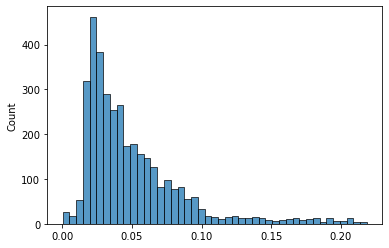

In [136]:
sns.histplot(prior_z_score_per_gene)

In [122]:
prior_z_score = np.nanmean(z_score_array_thresh, axis=0)

In [123]:
df_z_score_prior = pd.DataFrame(prior_z_score ,  index= bins_bed['bin_id'].tolist(), columns=['prior_val'])
df_z_score_prior['bin_id'] = df_z_score_prior.index.tolist()
df_z_score_prior.to_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/contact_top1/totg_reg_prior_only_top1_inter_zcore.csv', sep='\t', )


In [8]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [9]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    

In [11]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [12]:

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

#df_gene_tp = df_gene_tp.fillna(0)

NameError: name 'df_gene_tp_all_info_mean' is not defined

In [29]:
#df_gene_tp = df_gene_tp.fillna(0)

In [14]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()


In [15]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [17]:
import seaborn as sns
%matplotlib inline

In [18]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)

In [ ]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


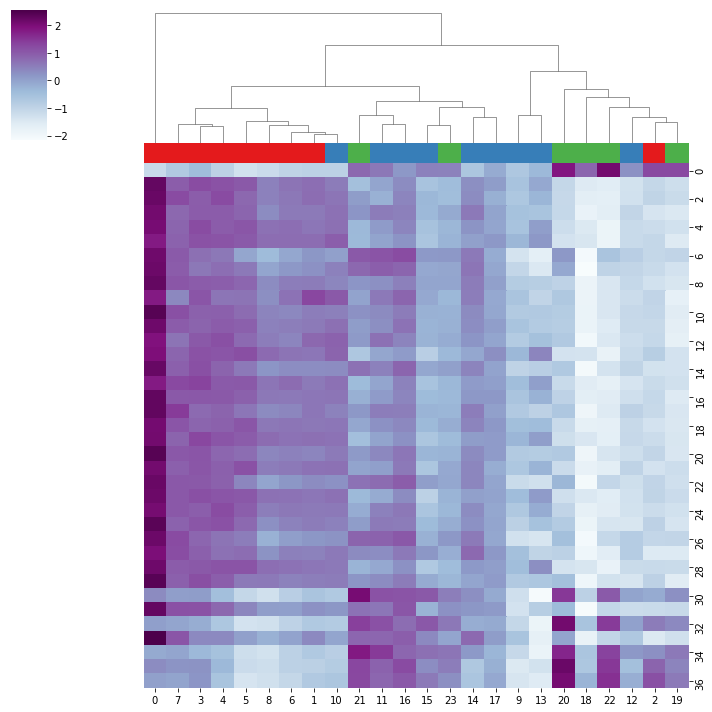

In [19]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


In [43]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'},  size=([10]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [24]:
len(all_bins_std[all_bins_std>=1].index.tolist())

383

In [49]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
#bin_random = random.sample(list(all_bins_pre), 50000)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [50]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
bin_random = random.sample(list(all_bins_pre), 50)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [47]:
#proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [45]:
#proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [ ]:
15

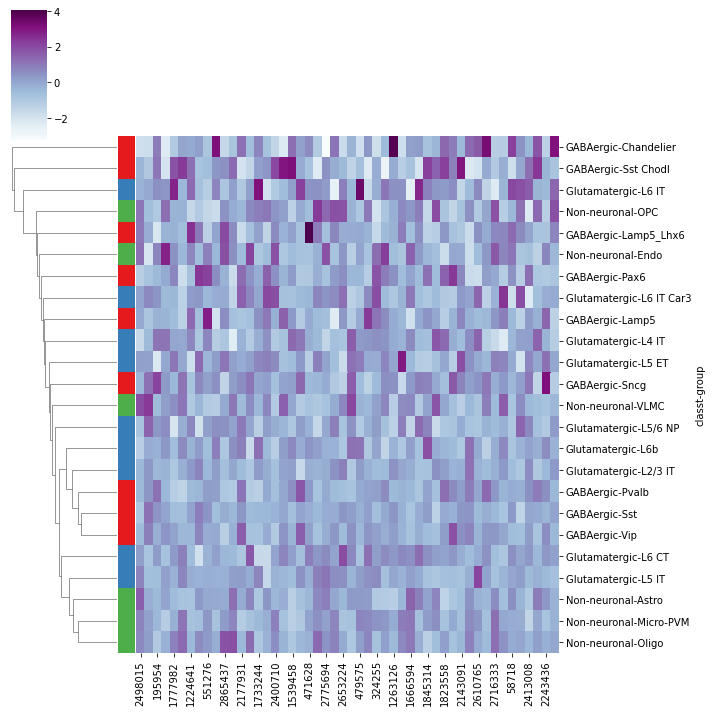

In [48]:
sns.clustermap(df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ], cmap="BuPu", col_cluster=False, row_cluster=True, robust=False, z_score=1, row_colors=[row_colors])


In [82]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [81]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [76]:
features.shape

(36, 24)

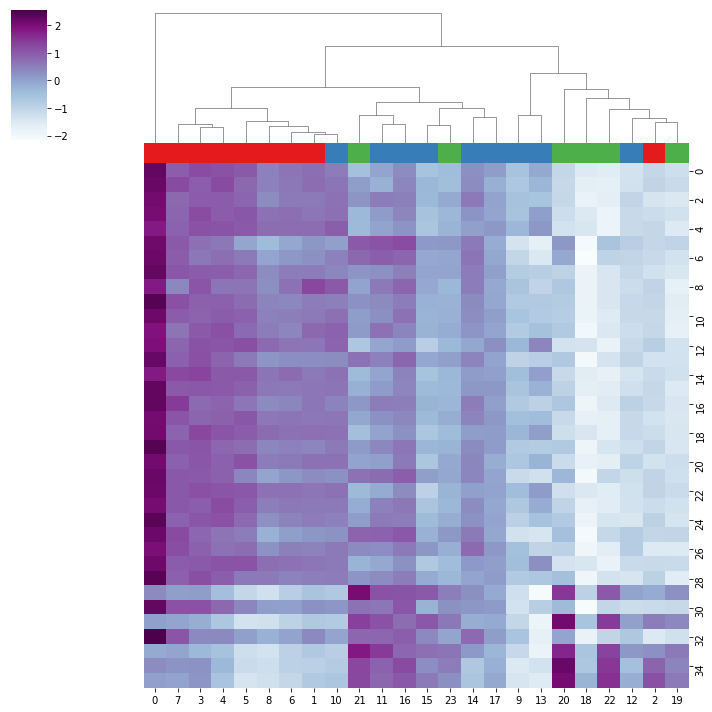

In [71]:
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


In [68]:
df_gene_tp_all_info_mean.reset_index()

classt       group         0         1         2         3  \
0       GABAergic  Chandelier -1.091419 -1.091419 -1.091419 -1.091419   
1       GABAergic       Lamp5 -0.954414 -0.954414 -0.954414 -0.954414   
2       GABAergic  Lamp5_Lhx6 -0.846578 -0.846578 -0.846578 -0.846578   
3       GABAergic        Pax6 -1.004080 -1.004080 -1.004080 -1.004080   
4       GABAergic       Pvalb -1.002590 -1.002590 -1.002590 -1.002590   
5       GABAergic        Sncg -0.968221 -0.968221 -0.968221 -0.968221   
6       GABAergic         Sst -0.961989 -0.961989 -0.961989 -0.961989   
7       GABAergic   Sst Chodl -1.014591 -1.014591 -1.014591 -1.014591   
8       GABAergic         Vip -0.947231 -0.947231 -0.947231 -0.947231   
9   Glutamatergic     L2/3 IT -0.867302 -0.867302 -0.867302 -0.867302   
10  Glutamatergic       L4 IT -0.947825 -0.947825 -0.947825 -0.947825   
11  Glutamatergic       L5 ET -0.982317 -0.982317 -0.982317 -0.982317   
12  Glutamatergic       L5 IT -0.844985 -0.844985 -0.844985 -0.844985   
13  Glutamatergic     L5/6 NP -0.882583 -0.882583 -0.882583 -0.882583   
14  Glutamatergic       L6 CT -0.964222 -0.964222 -0.964222 -0.964222   
15  Glutamatergic       L6 IT -0.924016 -0.924016 -0.924016 -0.924016   
16  Glutamatergic  L6 IT Car3 -0.965146 -0.965146 -0.965146 -0.965146   
17  Glutamatergic         L6b -0.930758 -0.930758 -0.930758 -0.930758   
18   Non-neuronal       Astro -0.805632 -0.805632 -0.805632 -0.805632   
19   Non-neuronal        Endo -0.852656 -0.852656 -0.852656 -0.852656   
20   Non-neuronal   Micro-PVM -0.886404 -0.886404 -0.886404 -0.886404   
21   Non-neuronal         OPC -0.921080 -0.921080 -0.921080 -0.921080   
22   Non-neuronal       Oligo -0.851876 -0.851876 -0.851876 -0.851876   
23   Non-neuronal        VLMC -0.910679 -0.910679 -0.910679 -0.910679   

           4         5         6         7  ...   2875002   2875003   2875004  \
0  -1.091419 -1.091419 -1.091419 -1.091419  ... -1.095077 -1.095077 -1.095077   
1  -0.954414 -0.954414 -0.954414 -0.954414  ... -0.973485 -0.973485 -0.973485   
2  -0.846578 -0.846578 -0.846578 -0.846578  ... -0.855263 -0.855263 -0.855263   
3  -1.004080 -1.004080 -1.004080 -1.004080  ... -0.996868 -0.996868 -0.996868   
4  -1.002590 -1.002590 -1.002590 -1.002590  ... -1.006892 -1.006892 -1.006892   
5  -0.968221 -0.968221 -0.968221 -0.968221  ... -0.978159 -0.978159 -0.978159   
6  -0.961989 -0.961989 -0.961989 -0.961989  ... -0.962013 -0.962013 -0.962013   
7  -1.014591 -1.014591 -1.014591 -1.014591  ... -0.996758 -0.996758 -0.996758   
8  -0.947231 -0.947231 -0.947231 -0.947231  ... -0.944837 -0.944837 -0.944837   
9  -0.867302 -0.867302 -0.867302 -0.867302  ... -0.866676 -0.866676 -0.866676   
10 -0.947825 -0.947825 -0.947825 -0.947825  ... -0.958794 -0.958794 -0.958794   
11 -0.982317 -0.982317 -0.982317 -0.982317  ... -0.987965 -0.987965 -0.987965   
12 -0.844985 -0.844985 -0.844985 -0.844985  ... -0.844492 -0.844492 -0.844492   
13 -0.882583 -0.882583 -0.882583 -0.882583  ... -0.878252 -0.878252 -0.878252   
14 -0.964222 -0.964222 -0.964222 -0.964222  ... -0.969003 -0.969003 -0.969003   
15 -0.924016 -0.924016 -0.924016 -0.924016  ... -0.891440 -0.891440 -0.891440   
16 -0.965146 -0.965146 -0.965146 -0.965146  ... -0.983997 -0.983997 -0.983997   
17 -0.930758 -0.930758 -0.930758 -0.930758  ... -0.922946 -0.922946 -0.922946   
18 -0.805632 -0.805632 -0.805632 -0.805632  ... -0.800982 -0.800982 -0.800982   
19 -0.852656 -0.852656 -0.852656 -0.852656  ... -0.845665 -0.845665 -0.845665   
20 -0.886404 -0.886404 -0.886404 -0.886404  ... -0.889262 -0.889262 -0.889262   
21 -0.921080 -0.921080 -0.921080 -0.921080  ... -0.938689 -0.938689 -0.938689   
22 -0.851876 -0.851876 -0.851876 -0.851876  ... -0.833301 -0.833301 -0.833301   
23 -0.910679 -0.910679 -0.910679 -0.910679  ... -0.906464 -0.906464 -0.906464   

     2875005   2875006   2875007   2875008   2875009   2875010   2875011  
0  -1.095077 -1.095077 -1.095077 -1.095077 -1.095077 -1.095077 -1.095077  
1  -0.973

In [51]:
import random
bin_random = random.sample(range(2875011), 5000)

In [62]:
bin_random = random.sample(all_bins, 10000)

In [79]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [49]:
import random
bin_random = random.sample(range(2875011), 1)

In [61]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [72]:
all_bins_std[all_bins_std > 0.20]

0          False
1          False
2          False
3          False
4          False
           ...  
2875007    False
2875008    False
2875009    False
2875010    False
2875011    False
Length: 2875012, dtype: bool

<AxesSubplot:ylabel='Count'>

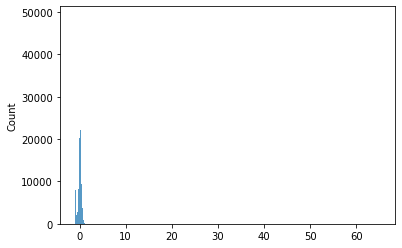

In [62]:
sns.histplot(all_bins_mean)

<AxesSubplot:ylabel='Count'>

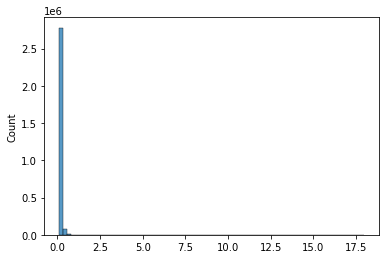

In [69]:
sns.histplot(all_bins_std, bins=80)

In [71]:
all_bins_std.median()

0.20387476682662964

In [105]:
all_bins_mean.max()

65.08242797851562

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

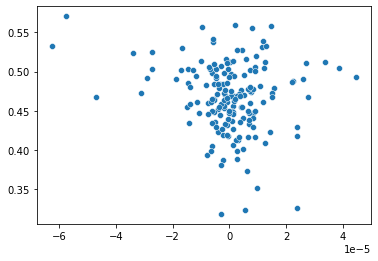

In [59]:
sns.scatterplot(all_bins_mean, all_bins_std)

In [139]:
import random
bin_random = random.sample(range(2875011), 10)

In [166]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 5]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 0.5].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 12].index.tolist()]

#features = df_gene_tp_all_info_mean.loc[:, bin_random]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [167]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [214]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


In [221]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Spectral", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)


In [170]:
all_bins_mean.median()

0.06591205298900604

In [207]:
df_gene_tp_all_info_mean = df_gene_tp_all_info_mean.sample(frac = 1)

In [179]:
df_gene_tp_all_info_mean

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395 -0.882395 -0.882395   
                        Chandelier_2 -0.785714 -0.785714 -0.785714 -0.785714   
             Lamp5      Lamp5_1      -0.927184 -0.927184 -0.927184 -0.927184   
                        Lamp5_2      -0.885508 -0.885508 -0.885508 -0.885508   
                        Lamp5_3      -0.898069 -0.898069 -0.898069 -0.898069   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464 -0.402464 -0.402464   
                        Oligo_8      -0.772555 -0.772555 -0.772555 -0.772555   
                        Oligo_9      -0.977664 -0.977664 -0.977664 -0.977664   
             VLMC       VLMC_1       -0.880988 -0.880988 -0.880988 -0.880988   
                        VLMC_2       -0.702171 -0.702171 -0.702171 -0.702171   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395 -0.882395 -0.882395   
                        Chandelier_2 -0.785714 -0.785714 -0.785714 -0.785714   
             Lamp5      Lamp5_1      -0.927184 -0.927184 -0.927184 -0.927184   
                        Lamp5_2      -0.885508 -0.885508 -0.885508 -0.885508   
                        Lamp5_3      -0.898069 -0.898069 -0.898069 -0.898069   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464 -0.402464 -0.402464   
                        Oligo_8      -0.772555 -0.772555 -0.772555 -0.772555   
                        Oligo_9      -0.977664 -0.977664 -0.977664 -0.977664   
             VLMC       VLMC_1       -0.880988 -0.880988 -0.880988 -0.880988   
                        VLMC_2       -0.702171 -0.702171 -0.702171 -0.702171   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395  ... -1.206051   
                        Chandelier_2 -0.785714 -0.785714  ... -0.919366   
             Lamp5      Lamp5_1      -0.927184 -0.927184  ... -1.018394   
                        Lamp5_2      -0.885508 -0.885508  ... -1.044661   
                        Lamp5_3      -0.898069 -0.898069  ... -1.052276   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464  ... -0.491964   
                        Oligo_8      -0.772555 -0.772555  ... -0.875512   
                        Oligo_9      -0.977664 -0.977664  ... -1.001657   
             VLMC       VLMC_1       -0.880988 -0.880988  ... -0.994492   
                        VLMC_2       -0.702171 -0.702171  ... -0.816006   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.206051 -1.206051 -1.206051 -1.206051   
                        Chandelier_2 -0.919366 -0.919366 -0.919366 -0.919366   
             Lamp5      Lamp5_1      -1.018394 -1.018394 -1.018394 -1.018394   
                        Lamp5_2      -1.044661 -1.044661 -1.044661 -1.044661   
                        Lamp5_3      -1.052276 -1.052276 -1.052276 -1.052276   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.491964 -0.491964 -0.491964 -0.491964   
                        Oligo_8      -0.875512 -0.875512 -0.875512 -0.875512   
                        Oligo_9      -1.001657 -1.001657 -1.001657 -1.001657   
             VLMC       VLMC_1       -0.994492 -0.994492 -0.994492 -0.994492   
                     

In [195]:
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 0.1].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff1f03a5dc0> (for post_execute):


KeyboardInterrupt: 

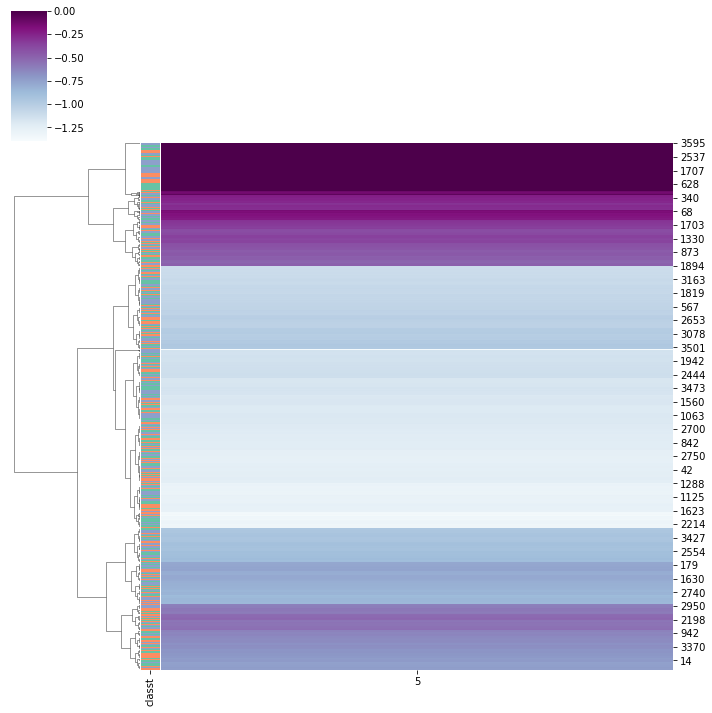

In [188]:
sns.clustermap(df_gene_tp.loc[:, [5]].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


In [202]:
row_colors

Index(['#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
       '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
       ...
       '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a',
       '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a'],
      dtype='object', name='classt', length=170)

In [219]:
row_colors2

Index(['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f',
       '#8da0cb', '#e5c494', '#b3b3b3', '#66c2a5',
       ...
       '#66c2a5', '#8da0cb', '#66c2a5', '#8da0cb', '#fc8d62', '#ffd92f',
       '#e5c494', '#e5c494', '#ffd92f', '#66c2a5'],
      dtype='object', name='group', length=170)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



KeyboardInterrupt: 

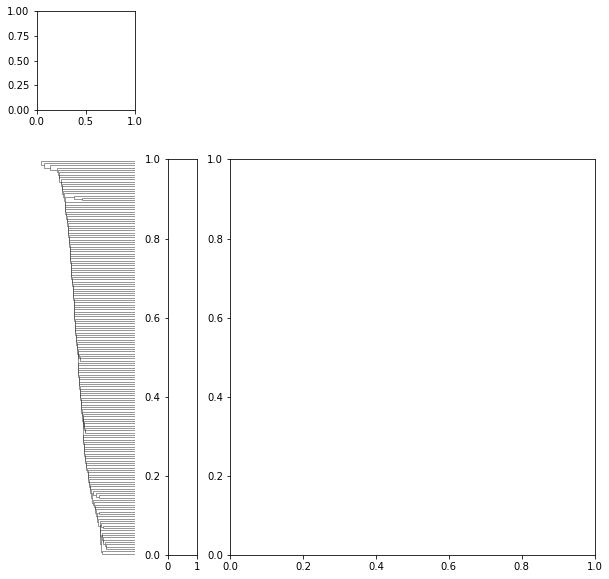

In [228]:
sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", row_colors=[row_colors2, row_colors], vmax=2)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



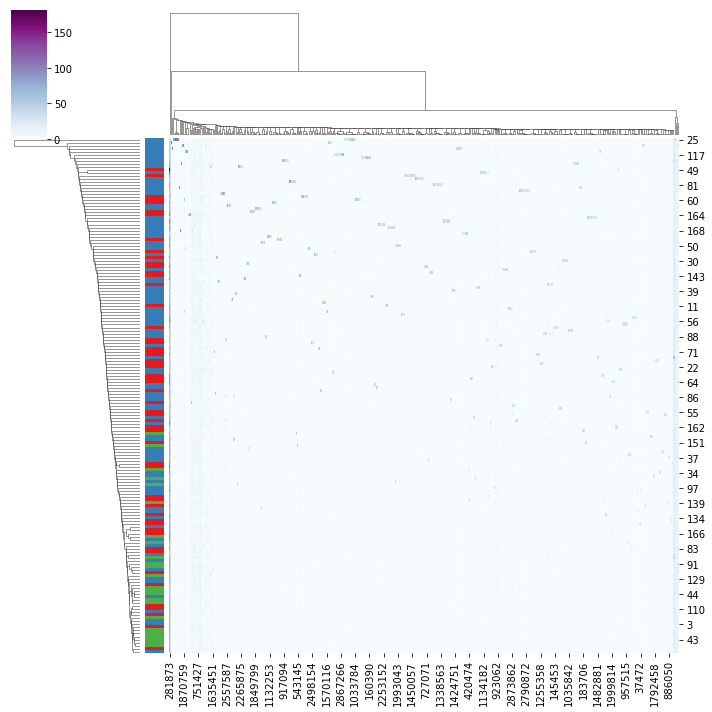

In [236]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 2].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors)


In [229]:
all_bins_std.max()

17.956958770751953

In [144]:
df_gene_tp.loc[:, bin_random].reset_index(drop=True)

2555762   679858    726613    1666589   2762339   2765508   1785609  \
0     0.454061 -1.002658 -1.002658  0.454061  0.454061  0.454061 -1.002658   
1    -0.359442 -0.359442 -0.359442  2.290267 -0.359442 -0.359442 -0.359442   
2     1.465658  0.132706  0.132706  0.132706  1.465658  0.132706  0.132706   
3     0.061154  0.000000  0.061154 -1.186174  0.061154  0.061154  0.061154   
4     1.424739 -1.174784 -1.174784  0.000000  0.124978  0.124978  0.124978   
...        ...       ...       ...       ...       ...       ...       ...   
3595  0.782952  0.782952 -0.815300 -0.815300  0.782952  0.782952 -0.815300   
3596 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594   
3597 -0.448294 -0.448294  1.833936  1.833936 -0.448294 -0.448294 -0.448294   
3598 -0.572756 -0.572756 -0.572756  1.212348 -0.572756 -0.572756 -0.572756   
3599 -0.358167  2.373816 -0.358167 -0.358167 -0.358167 -0.358167 -0.358167   

       1320335   2164707   2654422  
0     0.454061  0.454061 -1.002658  
1    -0.359442 -0.359442 -0.359442  
2     0.132706 -1.200246 -1.200246  
3     1.308483  0.061154 -1.186174  
4     0.124978 -1.174784 -1.174784  
...        ...       ...       ...  
3595 -0.815300  0.782952 -0.815300  
3596 -0.060594  1.170590 -1.291777  
3597 -0.448294  1.833936 -0.448294  
3598 -0.572756 -0.572756 -0.572756  
3599 -0.358167 -0.358167 -0.358167  

[3600 rows x 10 columns]

In [142]:
df_gene_tp_all_info_mean.index.get_level_values('classt')

Index(['GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       ...
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal'],
      dtype='object', name='classt', length=170)

In [131]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [9]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

In [11]:
marker_list = marker_list.sample(frac=1)

In [12]:
df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]



In [19]:
df_gene_tp_na = df_gene_tp.fillna(0)

In [14]:
import random
bin_random = random.sample(range(2875011), 1000)

In [21]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [16]:
import seaborn as sns
%matplotlib inline

In [186]:
lut = dict(zip( marker_list.classt.drop_duplicates(), sns.color_palette("Set2", marker_list.classt.drop_duplicates().shape[0]).as_hex()[:]))


row_colors = marker_list.classt.map(lut)

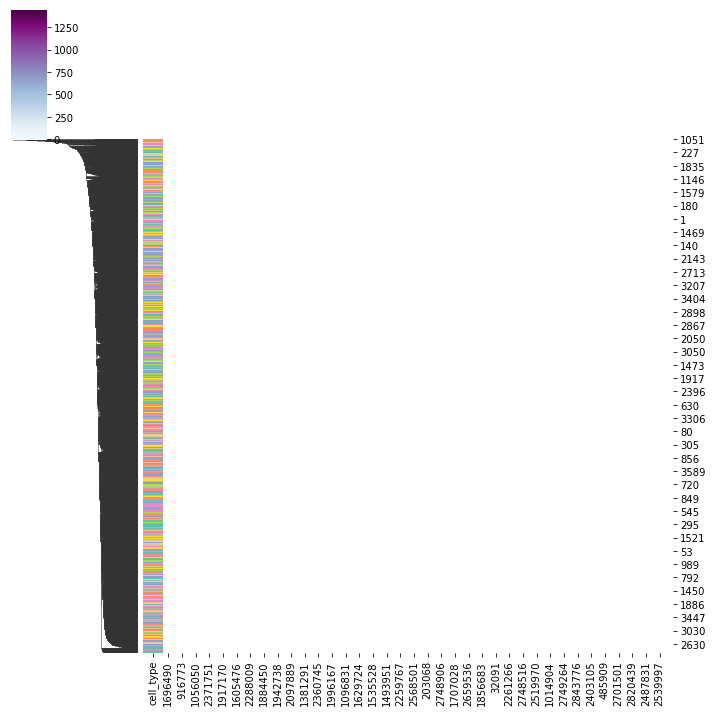

In [24]:
sns.clustermap(df_gene_tp_na.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", row_colors=row_colors.reset_index(drop=True), col_cluster=False, robust=False)


In [ ]:
sns.clustermap(df_gene_tp_na.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", row_colors=row_colors.reset_index(drop=True), col_cluster=False, robust=False)


In [ ]:
df_gene_tp = df_gene_tp.fillna(0)

<AxesSubplot:xlabel='0', ylabel='Count'>

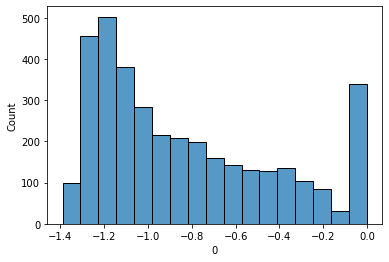

In [45]:
import seaborn as sns
%matplotlib inline
sns.histplot(df_gene_tp[0])

In [61]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    
    

In [ ]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, :]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [54]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [55]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}
)


fig_2d.show()

In [27]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}
)


fig_2d.show()

NameError: name 'px' is not defined

In [41]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [26]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

NameError: name 'px' is not defined